In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# CUDA_VERSION=11.6
# %pip install jaxlib

In [3]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax import jit

import gpjax as gpx
import tensorflow as tf

tf.random.set_seed(42)
key = jr.PRNGKey(123)

In [4]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import tqdm
from flax.training import train_state
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
# from utilities import plot
import tinygp
from tinygp import kernels, GaussianProcess
import tensorflow_probability.substrates.jax as tfp

dist = tfp.distributions

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess


XLA_PYTHON_CLIENT_PREALLOCATE=False

In [5]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]



In [6]:
def dataset_loader(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    # torch.set_default_dtype(torch.float64)
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
        

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
    
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_train.extend(jnp.array(x))
        y_train.extend(jnp.array(y))
        x_train_timestamp.extend(jnp.array(timestamp_train))


    x_train = jnp.array(x_train).reshape(-1, 1)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = jnp.array(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)



    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_test.extend(jnp.array(x))
        y_test.extend(jnp.array(y))
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test).reshape(-1, 1)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = jnp.array(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], 1)
    y_train = jnp.array(y_train).reshape(-1,)
    x_train_timestamp = jnp.array(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], 1)
    y_test = jnp.array(y_test).reshape(-1,)
    x_test_timestamp = jnp.array(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1)


    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time


In [7]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [8]:
x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time = dataset_loader(appliances, train, test)

In [9]:
x_train_full = jnp.concatenate((x_train, x_train_timestamp), axis=1)
x_test_full =jnp.concatenate((x_test, x_test_timestamp), axis=1)
x_train_full.shape, x_test_full.shape

((53456, 2), (16781, 2))

In [10]:
n_inducing_space = 10
z = x_train_full[jnp.arange(0,x_train_full.shape[0],n_inducing_space )]
z.shape

(5346, 2)

In [11]:
# fig, ax = plt.subplots(figsize=(12, 5))
# ax.plot(x_test, y_test, label="Latent function", color='tab:blue')
# ax.plot(x_train, y_train, "o", color="tab:orange",  alpha=0.4, label="Observations", markersize=2.5)
# [ax.axvline(x=z_i, color="tab:gray", alpha=0.3, linewidth=1) for z_i in z]
# ax.legend(loc="best")
# plt.show()

In [12]:
D = gpx.Dataset(X=x_train_full, y=y_train.reshape(-1,1))

In [13]:
from chex import dataclass
from tinygp.helpers import JAXArray,field
from tinygp.kernels.distance import Distance, L1Distance, L2Distance
from typing import Optional, List

@dataclass
class periodic(gpx.kernels.Kernel):
    # active_dims: Optional[List[int]] = None
    scale: JAXArray = field(default_factory=lambda: jnp.ones(()))
    distance: Distance = L1Distance()
    gamma: Optional[JAXArray] = 1.0

    def __post_init__(self):
        if jnp.ndim(self.scale):
            raise ValueError(
                "Only scalar scales are permitted for stationary kernels; use"
                "transforms.Linear or transforms.Cholesky for more flexiblity"
            )
        if self.gamma is None:
            raise ValueError("Missing required argument 'gamma'")

    def __call__(self, x: gpx.types.Array, y: gpx.types.Array, params: dict) -> gpx.types.Array:
        assert self.gamma is not None
        r = self.distance.distance(x, y) / self.scale
        return jnp.exp(-self.gamma * jnp.square(jnp.sin(jnp.pi * r)))


In [14]:
import tinygp
import jax
import jax.numpy as jnp



In [15]:
kernel1 = gpx.Matern52(active_dims=[0])
kernel2 = gpx.RBF(active_dims=[1])
# kernel3 = periodic(active_dims=[0])
# kernel4 = tinygp.kernels.ExpSineSquared(scale=jnp.array([4.0]), gamma=jnp.array([1.0]))
kernel = kernel1 + kernel2
likelihood = gpx.Gaussian(num_datapoints=D.n)
prior = gpx.Prior(kernel=kernel)
p = prior * likelihood

In [16]:
q = gpx.CollapsedVariationalGaussian(prior=prior, likelihood=likelihood, inducing_inputs=z)

In [17]:
sgpr = gpx.CollapsedVI(posterior=p, variational_family=q)

In [18]:
params, trainables, constrainers, unconstrainers = gpx.initialise(sgpr)

loss_fn = jit(sgpr.elbo(D, constrainers, negative=True))

optimiser = ox.adam(learning_rate=0.001)

params = gpx.transform(params, unconstrainers)

learned_params = gpx.fit(
    objective = loss_fn,
    params = params,
    trainables = trainables,
    optax_optim = optimiser,
    n_iters=2000,
)
learned_params = gpx.transform(learned_params, constrainers)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [20]:
latent_dist = q.predict(D, learned_params)(x_test_full)
predictive_dist = likelihood(latent_dist, learned_params)

# samples = latent_dist.sample(seed=key,sample_shape=20)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()


In [21]:
y_mean = scaler_y.inverse_transform(predictive_mean.reshape(-1,1)).squeeze()
y_sigma = scaler_y.inverse_transform(predictive_std.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean.shape)

(16781,) (16781,)


In [22]:
mae = jnp.mean(jnp.abs(jnp.array(y_test) - jnp.array(y_mean)))
rms = errors.rmse(jnp.array(y_test), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  47.06397176661299
RMSE:  66.09317846297658


In [23]:
def NLL(mean,sigma,y):
    def loss_fn(mean, sigma, y):
      d = dist.Normal(loc=mean, scale=sigma)
      return -d.log_prob(y)
    return jnp.mean(jax.vmap(loss_fn, in_axes=(0, 0, 0))(mean, sigma, y))

In [24]:
nll = NLL(jnp.array(y_mean), jnp.array(y_sigma), jnp.array(y_test))

print("NLL: ", nll)

NLL:  5.970729547049981


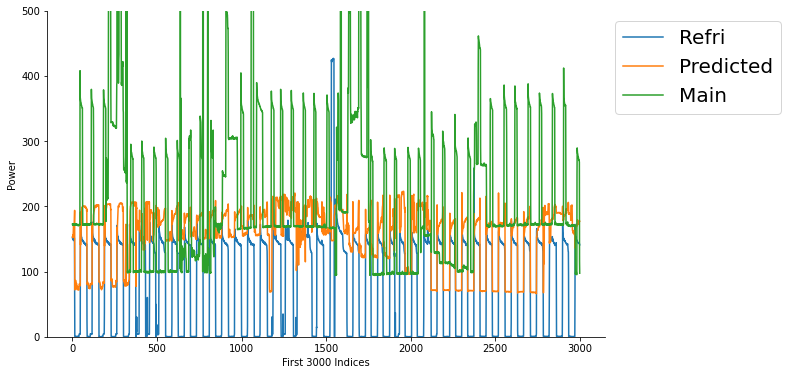

In [25]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test[:idx], label = "Refri")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.plot(jnp.arange(idx), scaler_x.inverse_transform(x_train)[:idx], label = "Main")
plt.ylim(0,500)
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("First 3000 Indices")
plt.ylabel("Power")
sns.despine()
plt.savefig("gpjax_ref_mat_rbf.png", bbox_inches="tight")

In [26]:
# idx = 3000
# plt.figure(figsize=(10,6))
# plt.plot(jnp.arange(idx), y_test[:idx], label = "Refrigerator", color="green")
# plt.plot(jnp.arange(idx), y_mean[:idx].reshape(-1,1), label = "Predicted")
# for i in range(1,4):
#     plt.fill_between(jnp.arange(idx), y_mean[:idx] - i*y_sigma[:idx], y_mean[:idx] + i*y_sigma[:idx],
#                     color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
# plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
# plt.ylabel("Power", fontsize=20)
# sns.despine()
# plt.savefig("gpjax_ref_full.png")

In [27]:
## MLP, XGBoost, RF - sklearn models